In [1]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

from sklearn.linear_model import LinearRegression, BayesianRidge, TweedieRegressor
from sklearn.svm import SVR
from sklearn.tree import ExtraTreeRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from pykrige.rk import RegressionKriging
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging
import gstools as gs

import warnings
warnings.simplefilter(action='ignore')

In [2]:
"""
Удаление выбросов с использованием межквартильного размаха (IQR)
"""
def get_filter_df(df, col):
    # Определяем Q1 и Q3 квартили
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    
    # Вычисляем IQR
    IQR = Q3 - Q1
    
    # Определяем границы для определения выбросов
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Фильтруем выбросы
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

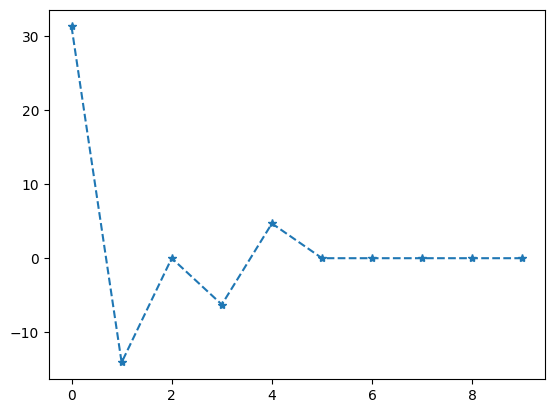

125.0 125.0


In [3]:
"""
Получение значений корреляции
"""
def get_corr(points, values, max_h, start=0, step=1):
    def matrix_distance_and_value(points, values):

        l = len(points)
        D = np.zeros((l, l))
        V = np.zeros((l, l))
        M = np.mean(values)

        for i in range(l):
            for j in range(i, l):
                distance = np.linalg.norm(points[i] - points[j])
                D[i, j] = distance
                V[i, j] = (values[i]-M)*(values[j]-M)
        return D, V
    
    
    corr_list, h_list = [], []
    D, V = matrix_distance_and_value(points, values)
    
    for h in range(start, max_h, step):
        corr_list.append(np.mean(np.where((D <= h) & (D > h-step), V, 0)))
        h_list.append(h)
    
    return np.array(h_list), np.array(corr_list)


# Пример построения корр функции
B = np.array([[1, 2, 3], [3, 4, 5], [1, 5, 7], [1, 2, 4]])
V = np.array([10, 20, 30, 40])
x, y = get_corr(B, V, 10)
plt.plot(x, y, "--*")
plt.show()
print(np.var(V), y[0]*4)

In [4]:
class MyCovModel(gs.CovModel):

    def __init__(self, dim=3, var=1.0, len_scale=1.0, nugget=0.0, anis=1.0, 
                 angles=0.0, 
                 **kwargs
                ):
        super().__init__(dim)
        self.var = var
        self.len_scale = len_scale
        self.nugget = nugget
        self.anis = anis
        self.angles = angles

        self.Dl = kwargs.get('Dl', .25)
        self.Df = kwargs.get('Df', .02)
        self.w = kwargs.get('w', 4)

    def cor(self, h):
        # Здесь определяем ковариационную функцию
        return self.Dl * np.exp(-np.abs(h)/self.len_scale) + self.Df * np.exp(-np.abs(h)/self.len_scale) * np.cos(h/self.w) + self.nugget


def my_cor_func(h, dl, df, al, af, w):
    dl=0.25
    return abs(dl)*np.exp(-abs(h)/al)*np.cos(h/w) + abs(df)*np.exp(-abs(h)/af)

In [5]:
r2_dict = {}

# Разбивка данных

In [6]:
"""
Чтение информации о скважинах
"""
df_boreholes = df_boreholes = pd.read_excel(f"data/координаты_скважин.xlsx")
house_3 = pd.read_excel("data/house_3_local.xlsx")

all_E = pd.DataFrame(columns=["borehole", "x", "y", "z", "h", "E"])

for borehole in house_3["тсз"]:
    """
    Запись данных по скважинам в один датафрейм
    """
    borehole_info = house_3[house_3["тсз"]==borehole]
    df_now = pd.read_excel(f"data/тсз{borehole}.xlsx")
    df_now = get_filter_df(df_now, "E").loc[:, ["h", "E"]]
    
    df_now["borehole"] = borehole 
    df_now["x"] = borehole_info["x"].iloc[0]
    df_now["y"] = borehole_info["y"].iloc[0]
    df_now["z"] = borehole_info["z"].iloc[0]

    all_E = pd.concat([all_E, df_now], ignore_index=True)

all_E["z_h"] = all_E["z"] - all_E["h"]
print(all_E.head(), all_E.shape)

"""
Деление без остатка абсолютной отметки на 1 и запись значение в 'group'
группировка и вычисление средних значений
"""
all_E["group"] = all_E["z_h"]//1
group_E = all_E.groupby(by=["group", "borehole"]).mean()
group_E["group"] = [int(x[0]) for x in group_E.index]
group_E["borehole"] = [int(x[1]) for x in group_E.index]

  borehole             x            y       z     h    E     z_h
0       51  97607.570697  4338.997129  76.631  0.00  0.0  76.631
1       51  97607.570697  4338.997129  76.631  0.05  6.0  76.581
2       51  97607.570697  4338.997129  76.631  0.10  6.0  76.531
3       51  97607.570697  4338.997129  76.631  0.15  6.0  76.481
4       51  97607.570697  4338.997129  76.631  0.20  6.0  76.431 (24429, 7)


In [7]:
"""
Разбивка данных на фиксированный шаг
"""
df_now = group_E.query('group == 65')

train = df_now.query('borehole >= 51 & borehole <=131')
test = df_now.query('borehole > 131')

p_train = train.loc[:, ["x", "y"]].to_numpy()
p_test = test.loc[:, ["x", "y"]].to_numpy()
x_train = train.loc[:, ["x", "y"]].to_numpy()
x_test = test.loc[:, ["x", "y"]].to_numpy()
target_train = train.loc[:, ["E"]].to_numpy().reshape(-1)
target_test = test.loc[:, ["E"]].to_numpy().reshape(-1)

In [8]:
"""
Случайная разбивка данных
"""
df_now = group_E.query('group == 65')

p = df_now.loc[:, ["x", "y"]].to_numpy() # Выборка для модели регрессии
x = df_now.loc[:, ["x", "y"]].to_numpy() # Выборка для кригинга
target = df_now["E"].to_numpy() # Известные значения

p_train, p_test, x_train, x_test, target_train, target_test = train_test_split(
    p, x, target, test_size=0.3, random_state=123
)

In [9]:
target_train.reshape(-1).shape

(67,)

# Универсальный кригинг

0.6132375187995017


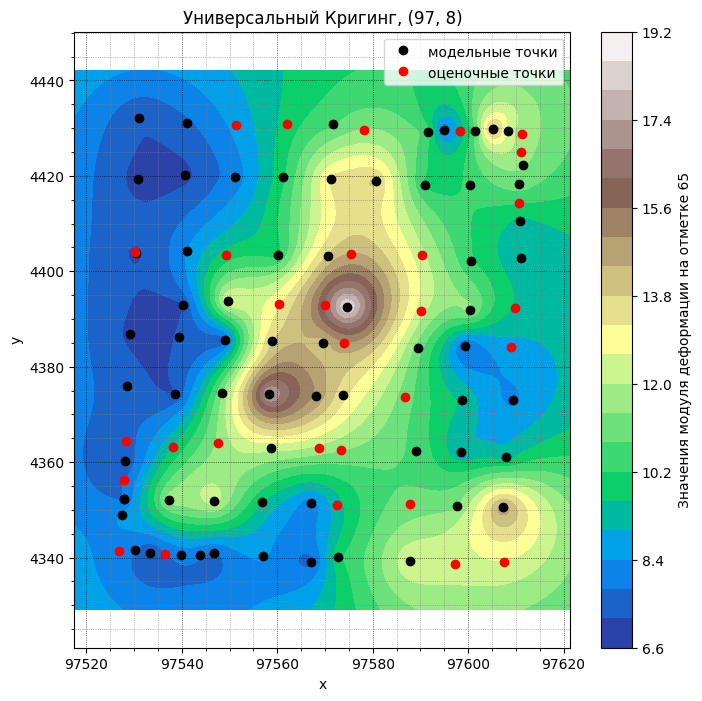

In [10]:
model = 'exponential'

x = x_train[:, 0]
y = x_train[:, 1]
E = target_train

labels = df_now["borehole"].to_numpy()#df_now["E"].apply(int).to_numpy()

OK = UniversalKriging(x, 
                         y, 
                         E, 
                         variogram_model=model,
                         variogram_parameters={'sill':28, 'range': 50, 'nugget': 1}
                        )


predict_test, var_test = OK.execute('points', x_test[:, 0], x_test[:, 1])
print(r2_score(target_test, predict_test))
r2_dict["UK"] = r2_score(target_test, predict_test)


x_new = np.linspace(np.min(x)-10, np.max(x)+10, 200)
y_new = np.linspace(np.min(y)-10, np.max(y)+10, 200)
    
z_new, variance = OK.execute('grid', x_new, y_new)
    
X, Y = np.meshgrid(x_new, y_new)
    
    
plt.figure(figsize=(8, 8))
    # Добавляем основную сетку
plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
    # Добавляем дополнительную сетку
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
    # Включаем дополнительные деления на осях
plt.minorticks_on()
    # Сохранение пропорций X Y
plt.axis('equal')
    
plt.contourf(X, Y, z_new, cmap='terrain', levels=20)
cbar = plt.colorbar()
cbar.set_label(f'Значения модуля деформации на отметке 65')


plt.plot(x, y, "ok", label="модельные точки")
plt.plot(x_test[:, 0], x_test[:, 1], "o", color="red", label="оценочные точки")
    
# for i in range(len(x)):
#         plt.scatter(x[i], y[i], color="k")
#         plt.annotate(labels[i], (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center')
    
plt.legend()    
plt.title(f'Универсальный Кригинг, {df_now.shape}')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Моя корр. функция в кригинге

In [11]:
"""
Подбор для MyCorr
"""
#pivot_r2 = pd.DataFrame(columns=[''])

top_r2 = 0
top_params = "mean"

dim = 2  # Размерность пространства
var = 1  # Дисперсия
nugget = 1
Df=0.5
Dl=0.5

for len_scale in [50]:  # Масштаб корреляции
    for w in range(1, 3):
        for anis in [i/10 for i in range(1, 11)]:  # Коэффициент анизотропии
            for angles in [i*10 for i in range(18)]:  # Угол поворота
                model= MyCovModel(dim=dim, var=var, len_scale=len_scale, 
                                  nugget=nugget, anis=anis, angles=angles, 
                                  w=w, 
                                  Df=Df, Dl=Dl
                                 )
                x = x_train[:, 0]
                y = x_train[:, 1]
                E = target_train
                OK = UniversalKriging(x, 
                                      y, 
                                      E, 
                                      variogram_model=model
                                     )
                try:
                    predict_test, var_test = OK.execute('points', x_test[:, 0], x_test[:, 1])
                    r2_now = r2_score(target_test, predict_test)
                    print(round(r2_now, 3), len_scale, nugget, anis, angles, w)
                    if top_r2 < r2_now:
                        top_r2 = r2_now
                        top_params = [len_scale, nugget, anis, angles, w]
                except ValueError as er:
                    print(er)

top_params_1 = top_params.copy()
print(top_r2, top_params)

0.357 50 1 0.1 0 1
-0.769 50 1 0.1 10 1
0.579 50 1 0.1 20 1
0.248 50 1 0.1 30 1
-0.428 50 1 0.1 40 1
0.588 50 1 0.1 50 1
-0.641 50 1 0.1 60 1
0.5 50 1 0.1 70 1
0.48 50 1 0.1 80 1
-0.377 50 1 0.1 90 1
-0.021 50 1 0.1 100 1
-22.334 50 1 0.1 110 1
-0.336 50 1 0.1 120 1
0.571 50 1 0.1 130 1
0.153 50 1 0.1 140 1
-0.427 50 1 0.1 150 1
0.574 50 1 0.1 160 1
-1.568 50 1 0.1 170 1
0.558 50 1 0.2 0 1
0.695 50 1 0.2 10 1
0.653 50 1 0.2 20 1
0.38 50 1 0.2 30 1
-0.097 50 1 0.2 40 1
0.482 50 1 0.2 50 1
0.619 50 1 0.2 60 1
0.715 50 1 0.2 70 1
0.511 50 1 0.2 80 1
0.18 50 1 0.2 90 1
0.14 50 1 0.2 100 1
0.566 50 1 0.2 110 1
0.702 50 1 0.2 120 1
0.63 50 1 0.2 130 1
0.358 50 1 0.2 140 1
-0.124 50 1 0.2 150 1
0.509 50 1 0.2 160 1
0.628 50 1 0.2 170 1
0.029 50 1 0.3 0 1
0.549 50 1 0.3 10 1
-0.208 50 1 0.3 20 1
0.523 50 1 0.3 30 1
0.173 50 1 0.3 40 1
0.511 50 1 0.3 50 1
0.258 50 1 0.3 60 1
0.541 50 1 0.3 70 1
0.585 50 1 0.3 80 1
0.352 50 1 0.3 90 1
0.326 50 1 0.3 100 1
-0.122 50 1 0.3 110 1
0.564 50 1 0.3 120

In [12]:
"""
Подбор для MyCorr 2 этап
"""
#pivot_r2 = pd.DataFrame(columns=[''])

top_r2 = 0
top_params = "mean"

dim = 2  # Размерность пространства
var = 1  # Дисперсия
len_scale, nugget, anis, angles, w = top_params_1

for w in range(1, 5):
    for Dl in [i/10 for i in range(5, 11)]:  # Коэффициент анизотропии
        for Df in [i/10 for i in range(1, 11)]:  # Угол поворота
                model= MyCovModel(dim=dim, var=var, len_scale=len_scale, nugget=nugget, 
                                  anis=anis, angles=angles, 
                                  w=w,
                                  Dl= Dl, Df= Df
                                 )
                x = x_train[:, 0]
                y = x_train[:, 1]
                E = target_train
                OK = UniversalKriging(x, 
                                      y, 
                                      E, 
                                      variogram_model=model
                                     )
                try:
                    predict_test, var_test = OK.execute('points', x_test[:, 0], x_test[:, 1])
                    r2_now = r2_score(target_test, predict_test)
                    print(round(r2_now, 3), w, Dl, Df)
                    if top_r2 < r2_now:
                        top_r2 = r2_now
                        top_params = [w, Dl, Df]
                except ValueError as er:
                    print(er)

top_params_2 = top_params.copy()
print(top_r2, top_params)

0.139 1 0.5 0.1
0.211 1 0.5 0.2
0.287 1 0.5 0.3
0.395 1 0.5 0.4
0.718 1 0.5 0.5
-1.187 1 0.5 0.6
-1.031 1 0.5 0.7
-0.072 1 0.5 0.8
-0.083 1 0.5 0.9
-2.774 1 0.5 1.0
0.175 1 0.6 0.1
0.265 1 0.6 0.2
0.382 1 0.6 0.3
-2.976 1 0.6 0.4
-0.888 1 0.6 0.5
-3.639 1 0.6 0.6
-0.004 1 0.6 0.7
-0.923 1 0.6 0.8
-124.348 1 0.6 0.9
-2.911 1 0.6 1.0
0.231 1 0.7 0.1
0.364 1 0.7 0.2
0.738 1 0.7 0.3
-0.691 1 0.7 0.4
-0.182 1 0.7 0.5
-0.197 1 0.7 0.6
-1947.786 1 0.7 0.7
-2.663 1 0.7 0.8
-1.115 1 0.7 0.9
-0.762 1 0.7 1.0
0.336 1 0.8 0.1
0.742 1 0.8 0.2
-0.892 1 0.8 0.3
-0.024 1 0.8 0.4
-16.28 1 0.8 0.5
-2.358 1 0.8 0.6
-0.955 1 0.8 0.7
-0.686 1 0.8 0.8
-0.596 1 0.8 0.9
-0.564 1 0.8 1.0
0.742 1 0.9 0.1
-1.104 1 0.9 0.2
-1.066 1 0.9 0.3
-1.987 1 0.9 0.4
-0.828 1 0.9 0.5
-0.665 1 0.9 0.6
-0.634 1 0.9 0.7
-0.642 1 0.9 0.8
-0.665 1 0.9 0.9
-0.694 1 0.9 1.0
-0.228 1 1.0 0.1
-1.622 1 1.0 0.2
-0.942 1 1.0 0.3
-0.934 1 1.0 0.4
-0.981 1 1.0 0.5
-1.033 1 1.0 0.6
-1.082 1 1.0 0.7
-1.125 1 1.0 0.8
-1.162 1 1.0 0.9
-1.195

0.7431926818009382


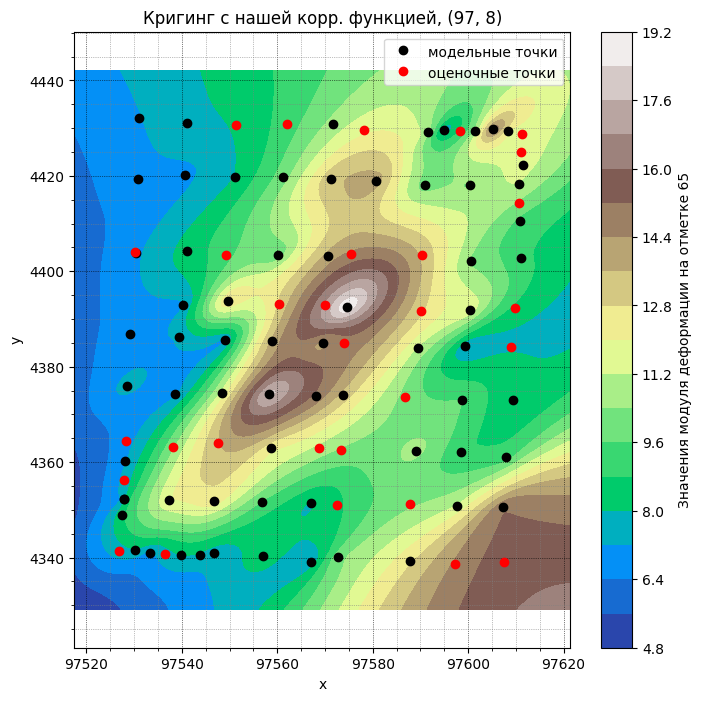

In [13]:
# Параметры модели
dim = 2  # Размерность пространства
var = 1.0  # Дисперсия
len_scale, nugget, anis, angles, w = top_params_1
w, Dl, Df = top_params_2

# Создание модели
model = MyCovModel(dim=dim, var=var, len_scale=len_scale, nugget=nugget, anis=anis, angles=angles, 
                   w=w,
                   Dl=Dl, Df=Df
                   )

x = x_train[:, 0]
y = x_train[:, 1]
E = target_train

labels = df_now["borehole"].to_numpy()

OK = UniversalKriging(x, 
                         y, 
                         E, 
                         variogram_model=model
                        )


predict_test, var_test = OK.execute('points', x_test[:, 0], x_test[:, 1])
print(r2_score(target_test, predict_test))
r2_dict["UK1"] = r2_score(target_test, predict_test)


x_new = np.linspace(np.min(x)-10, np.max(x)+10, 200)
y_new = np.linspace(np.min(y)-10, np.max(y)+10, 200)
    
z_new, variance = OK.execute('grid', x_new, y_new)
    
X, Y = np.meshgrid(x_new, y_new)
    
    
plt.figure(figsize=(8, 8))
    # Добавляем основную сетку
plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
    # Добавляем дополнительную сетку
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
    # Включаем дополнительные деления на осях
plt.minorticks_on()
    # Сохранение пропорций X Y
plt.axis('equal')
    
plt.contourf(X, Y, z_new, cmap='terrain', levels=20)
cbar = plt.colorbar()
cbar.set_label(f'Значения модуля деформации на отметке 65')

plt.plot(x, y, "ok", label="модельные точки")
plt.plot(x_test[:, 0], x_test[:, 1], "o", color="red", label="оценочные точки")


"""
for i in range(len(x)):
    if i==0:
        plt.scatter(x[0], y[0], color="k", label="train")
    else:
        plt.scatter(x[i], y[i], color="k")
    plt.annotate(labels[i], (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center')
    
for i in range(x_test.shape[0]):
    if i==0:
        plt.scatter(x_test[0, 0], x_test[0, 1], color="red", label="test")
    else:
        plt.scatter(x_test[i, 0], x_test[i, 1], color="red") 
"""

plt.legend()
plt.title(f'Кригинг с нашей корр. функцией, {df_now.shape}')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [14]:
model.Dl = top_params_2[1]
model.Df = top_params_2[2]

# Регрессия + кригинг

In [15]:
svr_model1 = SVR(C=0.1, gamma="auto", kernel='rbf')
svr_model2 = SVR(C=0.1, gamma="auto", kernel="sigmoid")
svr_model3 = SVR(C= 10, coef0= np.min(target_test), epsilon= 0.1, 
                 gamma= 'scale', kernel= 'sigmoid'
                )
lr_model = LinearRegression(copy_X=True, fit_intercept=False)
br_model = BayesianRidge()
et_model = ExtraTreeRegressor()
tr_model = TweedieRegressor()

In [16]:
p_train.shape, x_train.shape, target_train.shape

((67, 2), (67, 2), (67,))

In [17]:
model

MyCovModel(dim=2, var=1.0, len_scale=50.0, nugget=1.0, anis=[0.5], angles=[1.2e+02])

In [18]:
reg_models = [svr_model2, svr_model3, lr_model, br_model, et_model, tr_model]
name_models = ["SVR1", "SVR2", "LR", "BR", "ET", "TR"]
dict_models = {}

model_kind = 'exponential'

for i in range(len(reg_models)):
    m =reg_models[i]
    name = name_models[i]
    
    print("=" * 40)
    print("regression model:", m.__class__.__name__, name_models[i])
    
    try:
        m_rk = RegressionKriging(regression_model=m, n_closest_points=10, variogram_model=model)
        m_rk.fit(p_train, x_train, target_train)
        dict_models[name] = m_rk
        r2_dict[name] = m_rk.score(p_test, x_test, target_test)
        print("Regression Score: ", m_rk.regression_model.score(p_test, target_test))
        print("RK score: ", m_rk.score(p_test, x_test, target_test))
    except Exception as ex:
        print(ex)


regression model: SVR SVR1
Finished learning regression model
Finished kriging residuals
Regression Score:  -0.19621412112705405
RK score:  0.7327969708522684
regression model: SVR SVR2
Finished learning regression model
Finished kriging residuals
Regression Score:  -0.19621411883799045
RK score:  0.7327969708522696
regression model: LinearRegression LR
Finished learning regression model
Finished kriging residuals
Regression Score:  -0.08456997797682408
RK score:  0.7329099022654677
regression model: BayesianRidge BR
Finished learning regression model
Finished kriging residuals
Regression Score:  0.027815156399179197
RK score:  0.7328699793684519
regression model: ExtraTreeRegressor ET
Finished learning regression model
Finished kriging residuals
Regression Score:  0.404727149437078
RK score:  0.404727149437078
regression model: TweedieRegressor TR
Finished learning regression model
Finished kriging residuals
Regression Score:  0.037158519156605285
RK score:  0.7328537311806461


In [19]:
r2_dict["mean"] = r2_score(target_test, [np.mean(target_test)]*target_test.shape[0])
r2_dict

{'UK': 0.6132375187995017,
 'UK1': 0.7431926818009382,
 'SVR1': 0.7327969708522684,
 'SVR2': 0.7327969708522696,
 'LR': 0.7329099022654677,
 'BR': 0.7328699793684519,
 'ET': 0.404727149437078,
 'TR': 0.7328537311806461,
 'mean': 0.0}

"""
Визуализация всех регр. моделей + кригинг
"""
for m in range(len(reg_models)):
    
    reg_model_now = reg_models[m]

    m_rk = RegressionKriging(regression_model=reg_model_now, n_closest_points=30, variogram_model=model)
    m_rk.fit(p_train, x_train, target_train)
    size = (200, 200)

    x_new = np.linspace(np.min(x_train[:, 0])-25, np.max(x_train[:, 0])+25, size[0])
    y_new = np.linspace(np.min(x_train[:, 1])-25, np.max(x_train[:, 1])+25, size[1])
    X, Y = np.meshgrid(x_new, y_new)

    data = np.array([X.reshape(-1), Y.reshape(-1)]).T

    z_new = np.reshape(m_rk.predict(data, data), (size[0], size[1]))


    plt.figure(figsize=(10, 10))
    # Добавляем основную сетку
    plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
        # Добавляем дополнительную сетку
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
        # Включаем дополнительные деления на осях
    plt.minorticks_on()
    # Сохранение пропорций X Y
    plt.axis('equal')    
    plt.contourf(X, Y, z_new, cmap='terrain', levels=20)
    cbar = plt.colorbar()
    cbar.set_label(f'Значения модуля деформации на отметке 65')


    plt.plot(x_train[:, 0], x_train[:, 1], "ok", label="train")
    plt.plot(x_test[:, 0], x_test[:, 1], "o", color="red", label="test")

    plt.title(f'{name_models[m]} + Кригинг')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

## Подбор параметров для регр. кригинга и моей функции

In [20]:
"""
Подбор для MyCorr 1 группа
"""
top_r2 = 0
top_params = "mean"

dim = 2  # Размерность пространства
var = 1  # Дисперсия
nugget = 1
Dl = top_params_2[1]
Df = top_params_2[2]

for reg_model in [lr_model, br_model, tr_model]:
    for w in range(1, 5):  # масштаб cos
        for anis in [i/10 for i in range(1, 11)]:  # Коэффициент анизотропии
            for angles in [i*10 for i in range(18)]:  # Угол поворота
                    model= MyCovModel(dim=dim, var=var, len_scale=len_scale, nugget=nugget, anis=anis, angles=angles, 
                                      w=w,
                                      Dl=Dl, Df=Df
                                      )
                    m_rk = RegressionKriging(regression_model=reg_model, n_closest_points=30, variogram_model=model)
                    m_rk.fit(p_train, x_train, target_train)

                    r2_now = m_rk.score(p_test, x_test, target_test)
                    print(round(r2_now, 3), reg_model, len_scale, nugget, anis, angles, w)
                    
                    if top_r2 < r2_now:
                        top_r2 = r2_now
                        top_params = [reg_model, len_scale, nugget, anis, angles, w]

top_reg_params_1 = top_params
print(top_r2, top_params)

Finished learning regression model
Finished kriging residuals
-8.481 LinearRegression(fit_intercept=False) 50 1 0.1 0 1
Finished learning regression model
Finished kriging residuals
0.352 LinearRegression(fit_intercept=False) 50 1 0.1 10 1
Finished learning regression model
Finished kriging residuals
0.562 LinearRegression(fit_intercept=False) 50 1 0.1 20 1
Finished learning regression model
Finished kriging residuals
0.12 LinearRegression(fit_intercept=False) 50 1 0.1 30 1
Finished learning regression model
Finished kriging residuals
-0.32 LinearRegression(fit_intercept=False) 50 1 0.1 40 1
Finished learning regression model
Finished kriging residuals
0.523 LinearRegression(fit_intercept=False) 50 1 0.1 50 1
Finished learning regression model
Finished kriging residuals
0.427 LinearRegression(fit_intercept=False) 50 1 0.1 60 1
Finished learning regression model
Finished kriging residuals
0.446 LinearRegression(fit_intercept=False) 50 1 0.1 70 1
Finished learning regression model
Finish

In [21]:
"""
Подбор для MyCorr 2 группа
"""
top_r2 = 0
top_params = "mean"

dim = 2  # Размерность пространства
var = 1  # Дисперсия
reg_model, len_scale, nugget, anis, angles, w = top_reg_params_1

for w in range(1, 5):  # масштаб cos
    for Dl in [i/10 for i in range(5, 11)]:
        for Df in [i/10 for i in range(1, 11)]:
                    model= MyCovModel(dim=dim, var=var, len_scale=len_scale, nugget=nugget, anis=anis, angles=angles, 
                                      w=w,
                                      Dl=Dl, Df=Df
                                      )
                    m_rk = RegressionKriging(regression_model=reg_model, n_closest_points=30, variogram_model=model)
                    m_rk.fit(p_train, x_train, target_train)

                    r2_now = m_rk.score(p_test, x_test, target_test)
                    print(round(r2_now, 3), Dl, Df, w)
                    
                    if top_r2 < r2_now:
                        top_r2 = r2_now
                        top_params = [Dl, Df, w]

top_reg_params_2 = top_params
print(top_r2, top_params)

Finished learning regression model
Finished kriging residuals
0.248 0.5 0.1 1
Finished learning regression model
Finished kriging residuals
0.345 0.5 0.2 1
Finished learning regression model
Finished kriging residuals
0.452 0.5 0.3 1
Finished learning regression model
Finished kriging residuals
0.573 0.5 0.4 1
Finished learning regression model
Finished kriging residuals
0.732 0.5 0.5 1
Finished learning regression model
Finished kriging residuals
-301.689 0.5 0.6 1
Finished learning regression model
Finished kriging residuals
-17.821 0.5 0.7 1
Finished learning regression model
Finished kriging residuals
-14.749 0.5 0.8 1
Finished learning regression model
Finished kriging residuals
-56.141 0.5 0.9 1
Finished learning regression model
Finished kriging residuals
-223.763 0.5 1.0 1
Finished learning regression model
Finished kriging residuals
0.281 0.6 0.1 1
Finished learning regression model
Finished kriging residuals
0.404 0.6 0.2 1
Finished learning regression model
Finished kriging 

Finished learning regression model
Finished kriging residuals


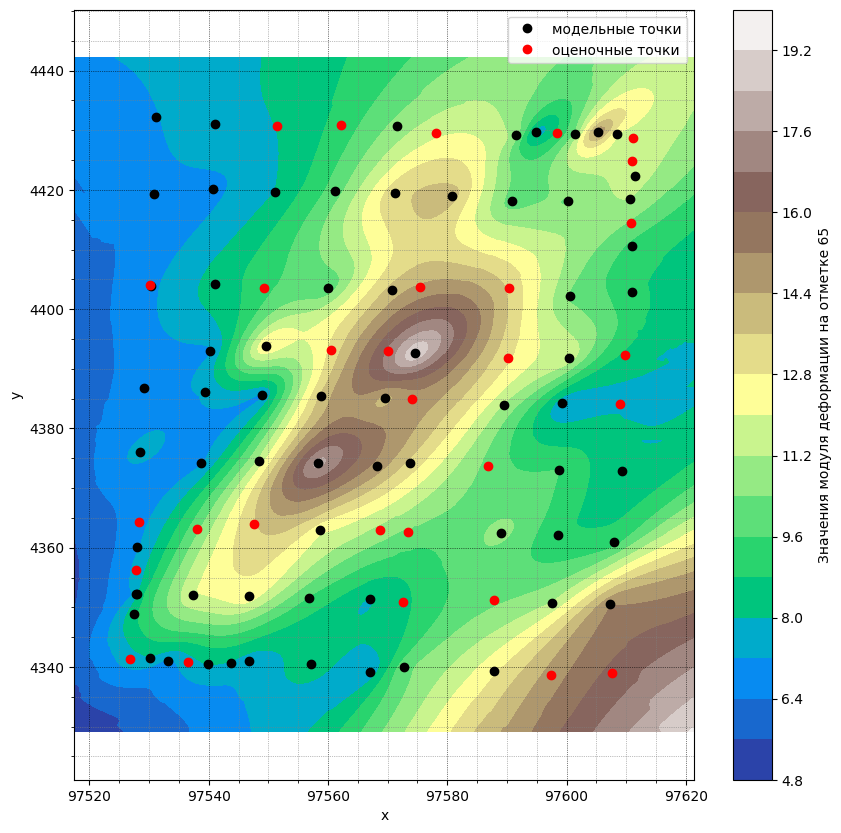

In [22]:
dim = 2  # Размерность пространства
var = 1  # Дисперсия
reg_model, len_scale, nugget, anis, angles, w = top_reg_params_1
Dl, Df, w = top_reg_params_2
model= MyCovModel(dim=dim, var=var, len_scale=len_scale, nugget=nugget, anis=anis, angles=angles, 
                  w=w,
                  Dl= Dl, Df=Df
                 )

m_rk = RegressionKriging(regression_model=reg_model, n_closest_points=30, variogram_model=model)
m_rk.fit(p_train, x_train, target_train)
size = (200, 200)

x_new = np.linspace(np.min(x_train[:, 0])-10, np.max(x_train[:, 0])+10, size[0])
y_new = np.linspace(np.min(x_train[:, 1])-10, np.max(x_train[:, 1])+10, size[1])
X, Y = np.meshgrid(x_new, y_new)

data = np.array([X.reshape(-1), Y.reshape(-1)]).T
z_new = np.reshape(m_rk.predict(data, data), (size[0], size[1]))


plt.figure(figsize=(10, 10))
    # Добавляем основную сетку
plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
        # Добавляем дополнительную сетку
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
        # Включаем дополнительные деления на осях
plt.minorticks_on()
    # Сохранение пропорций X Y
plt.axis('equal')    
plt.contourf(X, Y, z_new, cmap='terrain', levels=20)
cbar = plt.colorbar()
cbar.set_label(f'Значения модуля деформации на отметке 65')

plt.plot(x_train[:, 0], x_train[:, 1], "ok", label="модельные точки")
plt.plot(x_test[:, 0], x_test[:, 1], "o", color="red", label="оценочные точки")

plt.legend()
#plt.title(f'{reg_model} + Кригинг')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [23]:
"""
SVR параметры
"""
# Определение параметров для перебора
param_grid = {
    'coef0' : [0, np.min(target_test), np.max(target_test)],
    'C': [0.1, 1, 10],
    'kernel': ['sigmoid'],
    'gamma': ['auto', 'scale', "float"],
    'epsilon': [0.1, 0.5, 1]
}

# Создание модели SVR
svr = SVR()

# Создание объекта GridSearchCV для перебора параметров
grid_search = GridSearchCV(svr, param_grid, cv=5, 
                           #scoring='neg_mean_squared_error'
                          )

# Обучение модели с перебором параметров
grid_search.fit(p, target)

# Вывод лучших параметров и соответствующей ошибки
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'C': 10, 'coef0': np.float64(6.915000000000001), 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}
Best score: -0.6363873741998333


In [24]:
"""
Подбор для BayesianRidge
"""
# Определение параметров для перебора
param_grid = {
    'max_iter': [50, 100, 200, 300],

}
br = BayesianRidge()
# Создание объекта GridSearchCV для перебора параметров
grid_search = GridSearchCV(svr, param_grid, cv=5, 
                           #scoring='neg_mean_squared_error'
                          )

# Обучение модели с перебором параметров
grid_search.fit(p, target)

# Вывод лучших параметров и соответствующей ошибки
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'max_iter': 50}
Best score: -0.5350849441221998


## Построение по всем данным для всех высот

Finished learning regression model
Finished kriging residuals
62 array must not contain infs or NaNs
Finished learning regression model
Finished kriging residuals


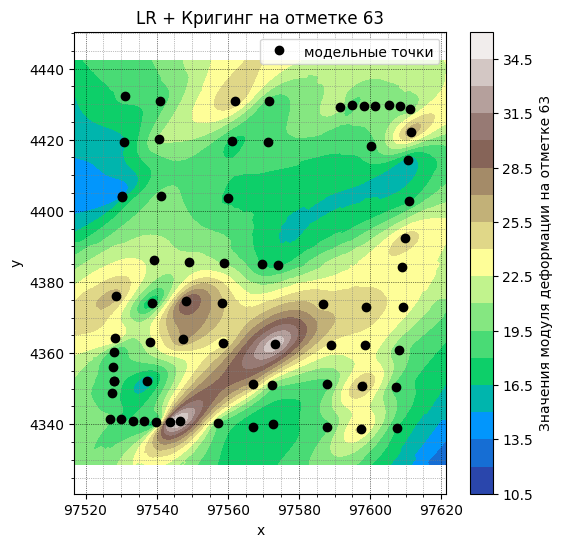

Finished learning regression model
Finished kriging residuals


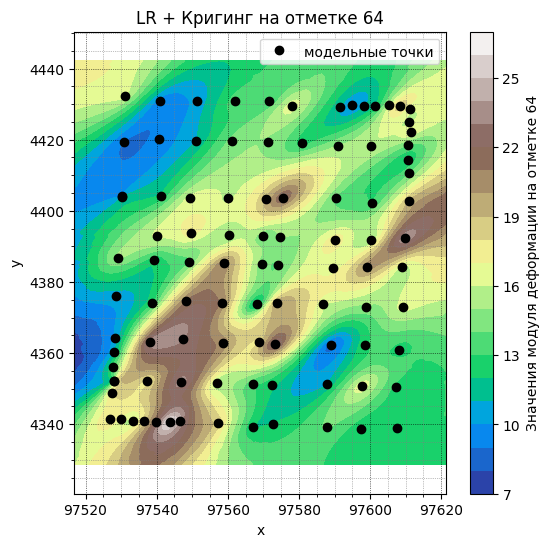

Finished learning regression model
Finished kriging residuals


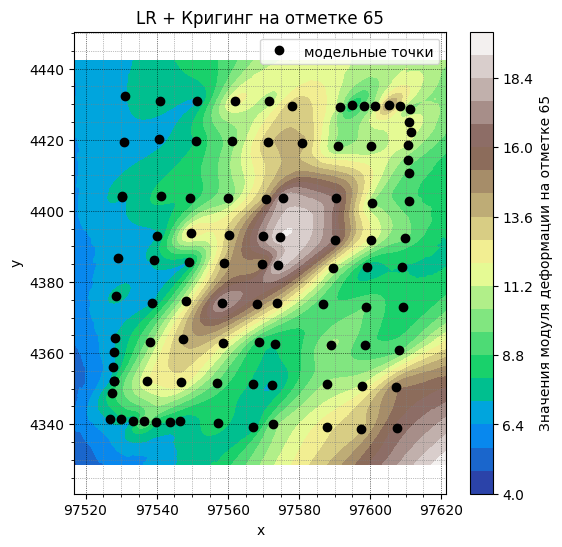

Finished learning regression model
Finished kriging residuals


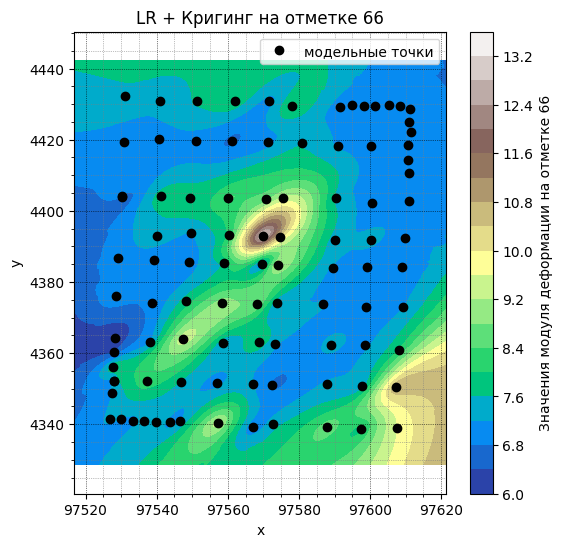

Finished learning regression model
Finished kriging residuals


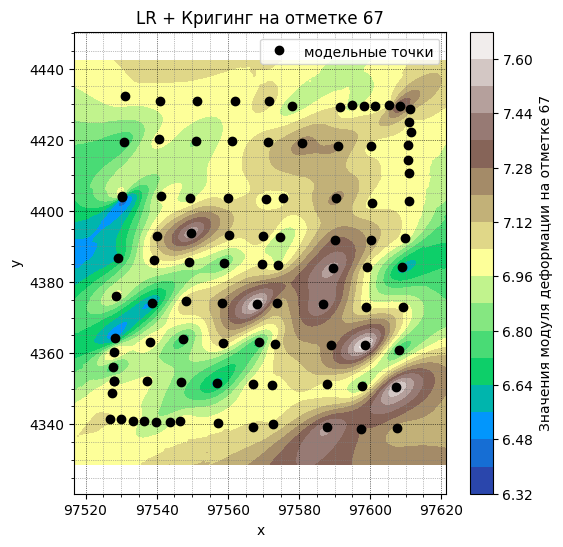

Finished learning regression model
Finished kriging residuals


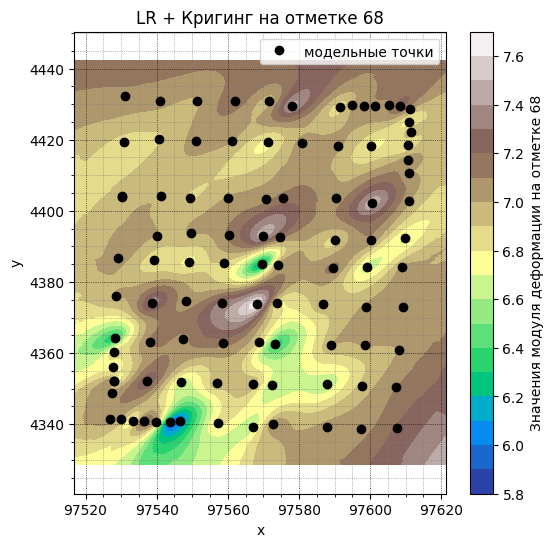

Finished learning regression model
Finished kriging residuals


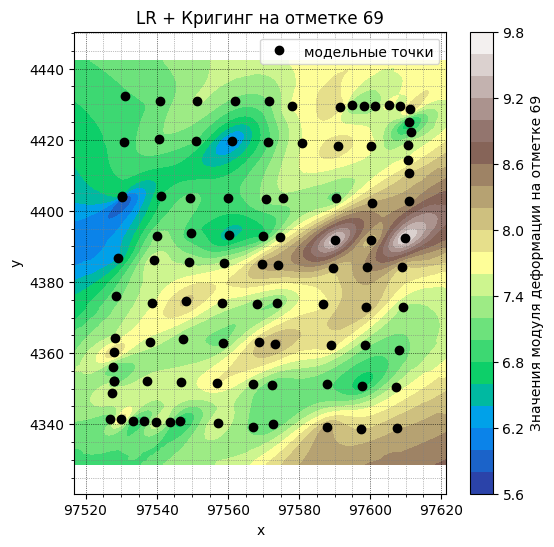

Finished learning regression model
Finished kriging residuals


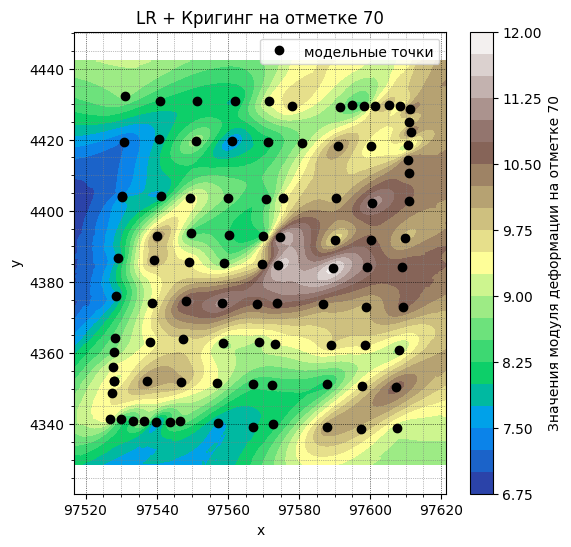

Finished learning regression model
Finished kriging residuals


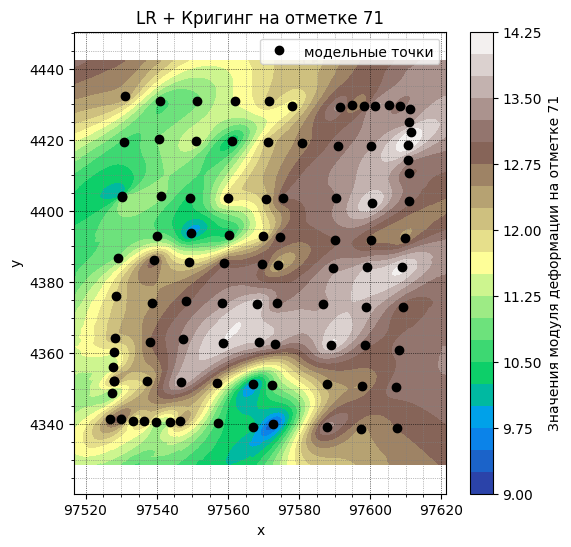

Finished learning regression model
Finished kriging residuals


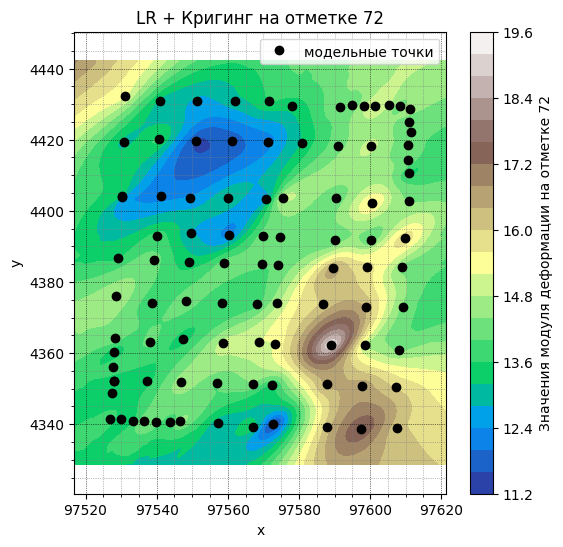

Finished learning regression model
Finished kriging residuals


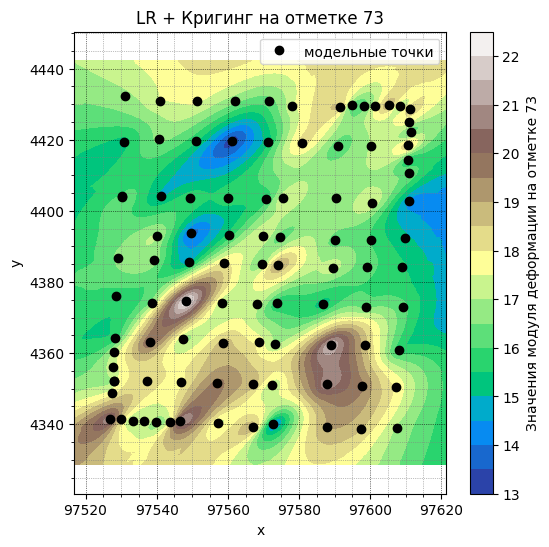

Finished learning regression model
Finished kriging residuals


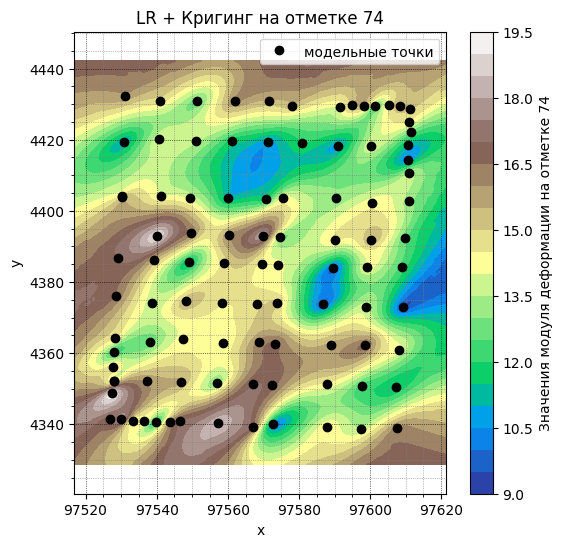

Finished learning regression model
Finished kriging residuals


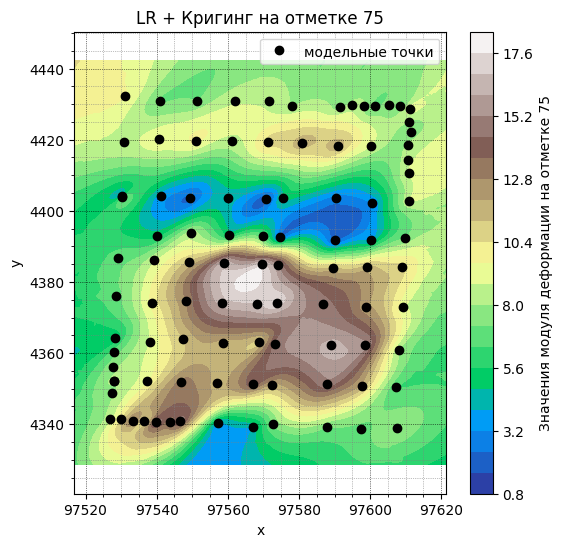

Finished learning regression model
Finished kriging residuals


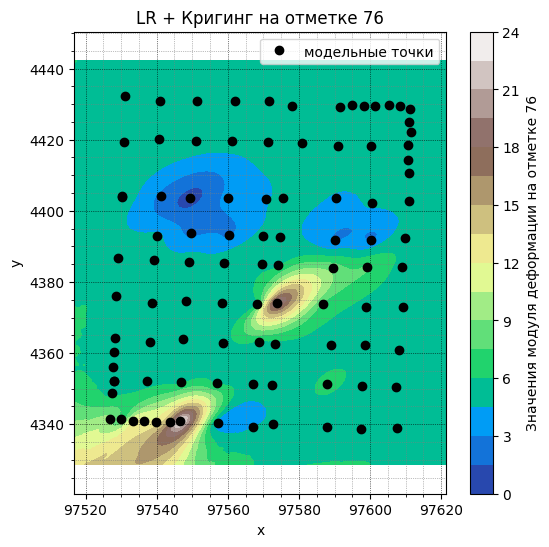

In [25]:
dim = 2  # Размерность пространства
var = 1  # Дисперсия
reg_model, len_scale, nugget, anis, angles, w = top_reg_params_1
Dl, Df, w = top_reg_params_2
model= MyCovModel(dim=dim, 
                  var=var, 
                  len_scale=len_scale, # ранг
                  nugget=nugget, # ошибка измерений
                  anis=anis, # коэф. анизотропии
                  angles=angles, # угол анизотропии
                  w=w,
                  Dl= Dl, Df=Df
                 )
m_rk = RegressionKriging(regression_model=reg_model, n_closest_points=30, variogram_model=model)

size = (200, 200)
x_new = np.linspace(group_E["x"].min()-10, group_E["x"].max()+10, size[0])
y_new = np.linspace(group_E["y"].min()-10, group_E["y"].max()+10, size[1])
X, Y = np.meshgrid(x_new, y_new)
data = np.array([X.reshape(-1), Y.reshape(-1)]).T

for group in group_E["group"].unique():
    df_now = group_E.query('group == @group')

    x = df_now.loc[:, ["x", "y"]].to_numpy()
    target = df_now["E"].to_numpy()
    m_rk.fit(x, x, target)
    try:
        z_new = np.reshape(m_rk.predict(data, data), (size[0], size[1]))
    except ValueError as er:
        print(group, er)
        continue

    plt.figure(figsize=(6, 6))
        # Добавляем основную сетку
    plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
            # Добавляем дополнительную сетку
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
            # Включаем дополнительные деления на осях
    plt.minorticks_on()
        # Сохранение пропорций X Y
    plt.axis('equal')    
    plt.contourf(X, Y, z_new, cmap='terrain', levels=20)
    cbar = plt.colorbar()
    cbar.set_label(f'Значения модуля деформации на отметке {group}')
    
    plt.plot(x[:, 0], x[:, 1], "ok", label="модельные точки")
    
    plt.legend()
    plt.title(f'LR + Кригинг на отметке {group}')
    #plt.title(f'{reg_model} + Кригинг')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

Finished learning regression model
Finished kriging residuals


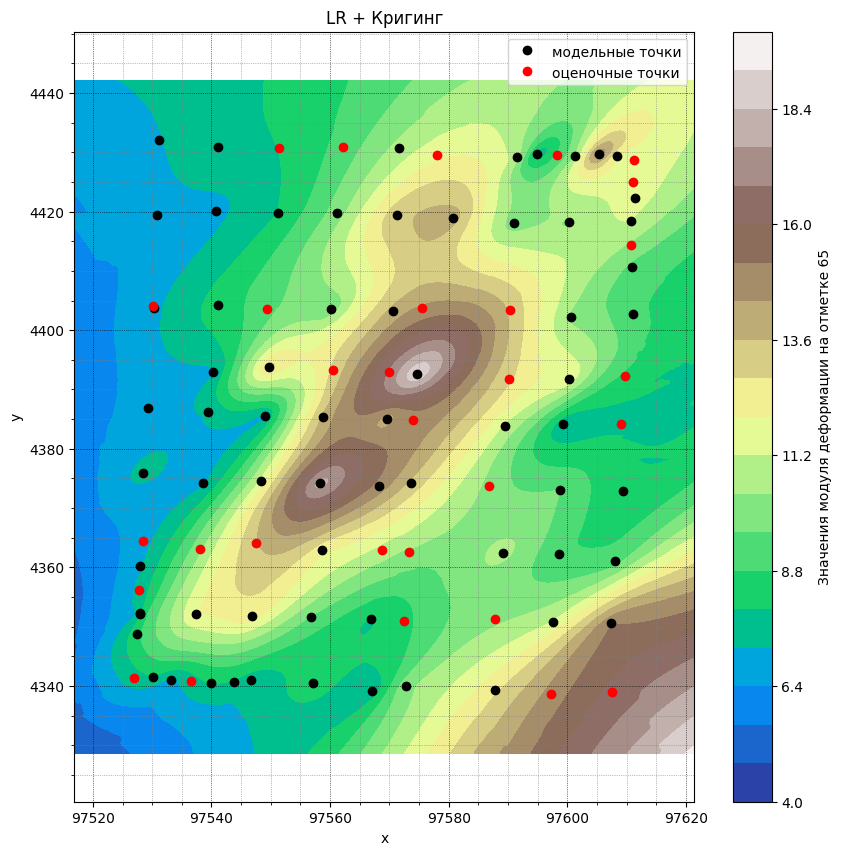

In [26]:
m_rk.fit(p_train, x_train, target_train)


z_new = np.reshape(m_rk.predict(data, data), (size[0], size[1]))


plt.figure(figsize=(10, 10))
    # Добавляем основную сетку
plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
        # Добавляем дополнительную сетку
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
        # Включаем дополнительные деления на осях
plt.minorticks_on()
    # Сохранение пропорций X Y
plt.axis('equal')
plt.contourf(X, Y, z_new, cmap='terrain', levels=20)
cbar = plt.colorbar()
cbar.set_label(f'Значения модуля деформации на отметке 65')

plt.plot(x_train[:, 0], x_train[:, 1], "ok", label="модельные точки")
plt.plot(x_test[:, 0], x_test[:, 1], "o", color="red", label="оценочные точки")

plt.legend()
plt.title(f'LR + Кригинг')
#plt.title(f'{reg_model} + Кригинг')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [27]:
group_E["group"].unique()

array([62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76])

In [28]:
class FindBadPoints():

    def __init__(self, points):
        self.points = points
        self.length = len(points)
        
        self.diff_max = 0
        self.diff_p1 = None
        self.diff_p2 = None

        self.sett_max = 0
        self.sett_p1 = None
        self.sett_p2 = None
        
    def fit(self):
        for i in range(self.length - 1):
            point_1 = self.points[i]

            for j in range(i + 1, self.length):
                point_2 = self.points[j]

                distance = ((point_1[1] - point_2[1]) ** 2 + (point_1[0] - point_2[0]) ** 2) ** (1 / 2)
                diff = abs(point_1[2] - point_2[2])
                sett = diff / distance

                if self.diff_max < diff:
                    self.diff_max = diff
                    self.diff_p1 = point_1.copy()
                    self.diff_p2 = point_2.copy()

                if self.sett_max < sett:
                    self.sett_max = sett
                    self.sett_p1 = point_1.copy()
                    self.sett_p2 = point_2.copy()
        
    def get_sett(self):
        return self.sett_max, self.sett_p1, self.sett_p2

    def get_diff(self):
        return self.diff_max, self.diff_p1, self.diff_p2


# example
points = np.array([[0, 0, 10],
                   [1, 1, 11],
                   [2, 2, 12],
                   [5, 5, 16],
                   [6, 6, 16]
                  ])


A = FindBadPoints(points)
A.fit()
print(A.get_diff())
print(A.get_sett())


(np.int64(6), array([ 0,  0, 10]), array([ 5,  5, 16]))
(np.float64(0.9428090415820635), array([ 2,  2, 12]), array([ 5,  5, 16]))


Finished learning regression model
Finished kriging residuals
0.751206177774479 4.600516948339493
(2500,)


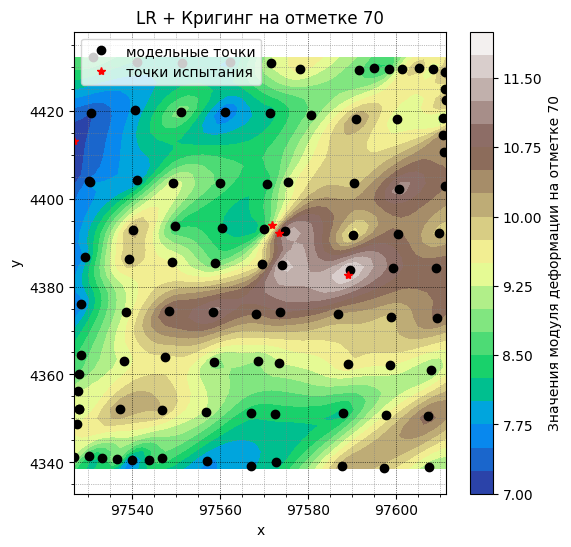

Finished learning regression model
Finished kriging residuals
0.5456432159099835 4.871719851155323
(2500,)


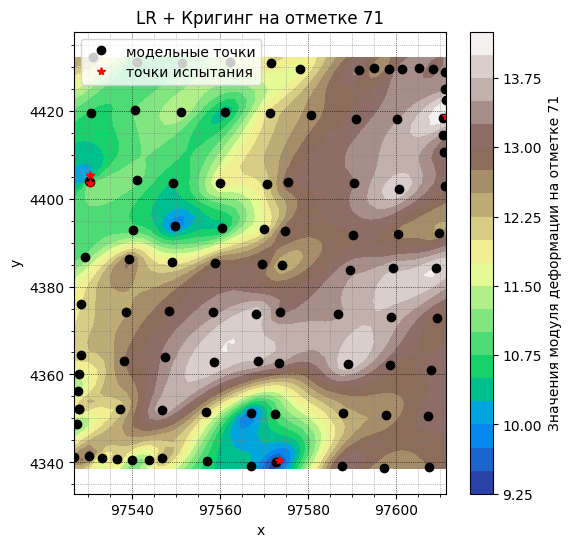

Finished learning regression model
Finished kriging residuals
0.5647298560431908 7.421499156237953
(2500,)


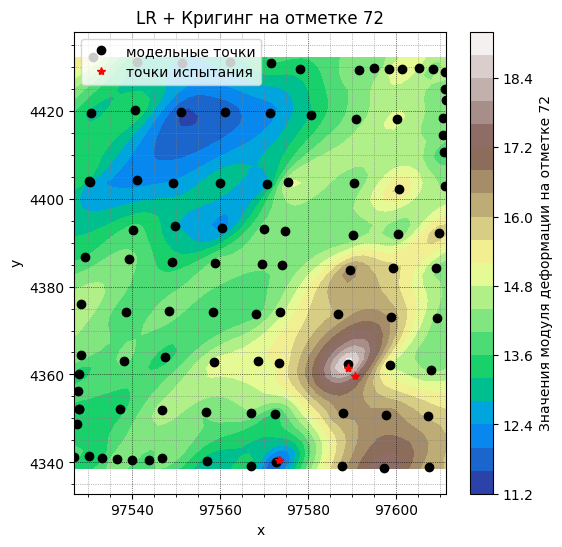

Finished learning regression model
Finished kriging residuals
1.4995979796235208 8.790876773490709
(2500,)


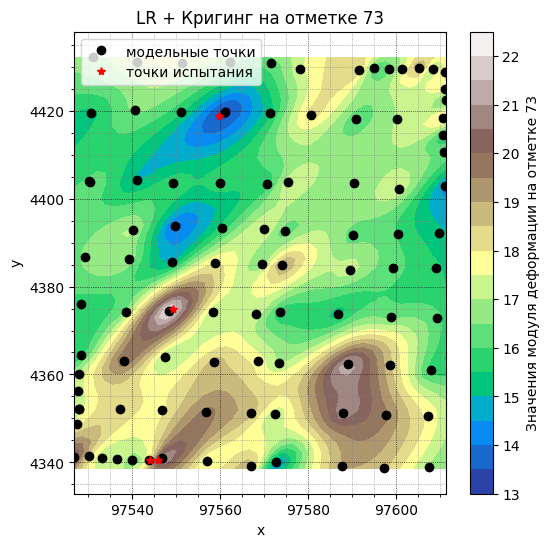

In [29]:
dim = 2  # Размерность пространства
var = 1  # Дисперсия
reg_model, len_scale, nugget, anis, angles, w = top_reg_params_1
Dl, Df, w = top_reg_params_2
model= MyCovModel(dim=dim, 
                  var=var, 
                  len_scale=len_scale, # ранг
                  nugget=nugget, # ошибка измерений
                  anis=anis, # коэф. анизотропии
                  angles=angles, # угол анизотропии
                  w=w,
                  Dl= Dl, Df=Df
                 )
m_rk = RegressionKriging(regression_model=reg_model, n_closest_points=30, variogram_model=model)

size = (50, 50)
x_new = np.linspace(group_E["x"].min(), group_E["x"].max(), size[0])
y_new = np.linspace(group_E["y"].min(), group_E["y"].max(), size[1])
X, Y = np.meshgrid(x_new, y_new)
data = np.array([X.reshape(-1), Y.reshape(-1)]).T

for group in [70, 71, 72, 73]:
    df_now = group_E.query('group == @group')

    x = df_now.loc[:, ["x", "y"]].to_numpy()
    target = df_now["E"].to_numpy()
    m_rk.fit(x, x, target)

    predict = m_rk.predict(data, data)

    BadPoints = FindBadPoints(np.concatenate([data, predict.reshape(-1, 1)], axis=1))
    BadPoints.fit()
    sett, point_s1, point_s2 = BadPoints.get_sett()
    diff, point_d1, point_d2 = BadPoints.get_diff()
    print(sett, diff)

    z_new = np.reshape(predict, (size[0], size[1]))


    print(m_rk.predict(data, data).shape)
        
    plt.figure(figsize=(6, 6))
        # Добавляем основную сетку
    plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
            # Добавляем дополнительную сетку
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
            # Включаем дополнительные деления на осях
    plt.minorticks_on()
        # Сохранение пропорций X Y
    plt.axis('equal')    
    plt.contourf(X, Y, z_new, cmap='terrain', levels=20)
    cbar = plt.colorbar()
    cbar.set_label(f'Значения модуля деформации на отметке {group}')
    
    plt.plot(x[:, 0], x[:, 1], "ok", label="модельные точки")

    plt.plot([point_d1[0], point_d2[0], point_s1[0], point_s2[0]], [point_d1[1], point_d2[1], point_s1[1], point_s2[1]], "*r", label="точки испытания")
    
    plt.legend()
    plt.title(f'LR + Кригинг на отметке {group}')
    #plt.title(f'{reg_model} + Кригинг')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

In [30]:
reg_model, len_scale, nugget, anis, angles, w

(LinearRegression(fit_intercept=False), 50, 1, 0.5, 120, 2)

In [31]:
data.shape

(2500, 2)

In [32]:
print(point_sett_1)
print(point_sett_2)
plt.plot(np.concatenate([point_sett_1[:])

SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (1774859672.py, line 3)

In [ ]:
np.concatenate([point_sett_1[:2].reshape(1, -1), point_sett_2[:2].reshape(1, -1)], axis=0).shape